<a href="https://colab.research.google.com/github/hejazn86/Stock_price_prediction/blob/main/stock_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Data Fetching and Saving**


## **Extracting Stock data from Yahoo API**

In this notebook, we will first, fetch historical stock data for Apple (AAPL) using the `yfinance` library, and save the data to a CSV file.


1. **Install yfinance Library**:
    - We use the `yfinance` library to fetch historical stock data.
    - If `yfinance` is not installed, uncomment the installation line and run it.

2. **Import Libraries**:
    - We import the `yfinance` library as `yf`.

3. **Define Variables**:
    - `ticker`: The stock ticker symbol for Apple (AAPL).
    - `start_date`: The start date for fetching historical data.
    - `end_date`: The end date for fetching historical data.

4. **Fetch Historical Stock Data**:
    - We use the `yf.download` method to fetch historical stock data for Apple within the defined date range.

5. **Save the Data**:
    - The fetched data is saved to a CSV file named `stock_price.csv`.



In [ ]:
# Install and import yfinance library
#!pip install yfinance
import yfinance as yf

# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2018-01-01'
end_date = '2024-02-01'

# Fetch historical stock data of specific company (Apple)
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Save the data
stock_data.to_csv('stock_price.csv')
len(stock_data)

[*********************100%%**********************]  1 of 1 completed


1530

## **Extracting Stock data using Alpha vantage API**

In [ ]:
# Install and load Alpha Vantage API
#!pip install alpha_vantage
#!pip install python-dotenv
#from alpha_vantage.timeseries import TimeSeries
#import pandas as pd

#from dotenv import load_dotenv
#import os

#load_dotenv()

# API key
#api_key = os.getenv('API_KEY')

# Initialize the TimeSeries class
#ts = TimeSeries(key=api_key, output_format='pandas')

# Get historical data for a given ticker
#ticker = 'AAPL'
#data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')

#data.to_csv('stock_vantage.csv')
#print(data.head())
#len(data)

## **Data Processing and Feature Engineering**

we will perform various data analysis and feature engineering techniques on stock price data. This includes calculating **moving averages**, **volatility**, **RSI**, and **MACD**.

- **Check for Missing Values**

We check for missing values in the dataset to ensure data quality.

- **Feature Engineering**

We extract the year and the month from the date for further analysis.

- **Calculate Simple Moving Average (SMA)**

We calculate the 10-day and 100-day simple moving averages to analyze the stock's trend.

- **Calculate Exponential Moving Average (EMA)**

We calculate the 10-day and 100-day exponential moving averages to analyze the stock's trend with more recent data weighted more heavily.

- **Calculate Volatility**

We calculate the annualized volatility of the stock's returns.

- **Calculate Relative Strength Index (RSI)**

We calculate the 14-day RSI to identify overbought or oversold conditions in the stock's price.

- **Calculate Moving Average Convergence Divergence (MACD)**

We calculate the MACD and Signal Line to identify changes in the strength, direction, momentum, and duration of a trend in the stock's price.


In [ ]:
import pandas as pd
import numpy as np

# Load the data
stock_data = pd.read_csv('stock_price.csv')

# check for missing values
stock_data.isnull().sum()

# Feature enginerring : extracting the year and the month
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)
stock_data['Year'] = stock_data.index.year
stock_data['Month'] = stock_data.index.month

# Calculate the Simple Moving average of the stocks
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean().fillna(method='bfill')
stock_data['SMA_100'] = stock_data['Close'].rolling(window=100).mean().fillna(method='bfill')

# Calculating The Exponential Moving Average
stock_data['EMA_10'] = stock_data['Close'].ewm(span= 10, adjust = False).mean().fillna(method='bfill')
stock_data['EMA_100'] = stock_data['Close'].ewm(span=100, adjust=False).mean().fillna(method='bfill')

# Calculate the Volatility (Annual)
#stock_data['Range'] = stock_data['High'] - stock_data['Low']
stock_data['Returns'] = stock_data['Close'].pct_change().fillna(method='bfill')
stock_data['Volatility'] = stock_data['Returns'].rolling(window = 10).std()* np.sqrt(252)
stock_data['Volatility'] = stock_data['Volatility'].fillna(method='bfill')
# Calculate Momentum Indicators: Relative Strength Index (RSI)
def RelativeStrengthIndex (series, period=14):
    delta = series.diff(1) # get the daily price change
    gain = delta.where(delta > 0, 0)                    # create a series with only the positive price changes
    loss = -delta.where(delta < 0, 0)                   # create a series with only the negative price changes
    avg_gain = gain.rolling(window=period).mean()       #calculate the moving average for the positive changes
    avg_loss = loss.rolling(window=period).mean()       # calculate the moving average for the negative changes
    retrnStr = avg_gain / avg_loss                      # calulate the relative strength
    retrnStridx = 100 - (100 / (1 + retrnStr))          # calculate the index
    return retrnStridx

stock_data['RSI_14'] = RelativeStrengthIndex(stock_data['Close']).fillna(method='bfill')


#  Calculate Momentum Indicators: Moving Average Convergence Divergence (MACD)
def MovingAverageConvergDiverg (series, shortPeriod=12, longPeriod=26, signalPeriod=9):
  seriesEMA12 = series.ewm(span=shortPeriod, adjust=False).mean()
  seriesEMA26 = series.ewm(span=longPeriod, adjust=False).mean()
  MACD = seriesEMA12 - seriesEMA26
  signalLine = MACD.ewm(span=signalPeriod, adjust=False).mean()
  return MACD, signalLine


MACD, SignalLine = MovingAverageConvergDiverg(stock_data['Close'])
stock_data['MACD'] = MACD
stock_data['SignalLine'] = SignalLine



##**Exploratory Data Analysis (EDA)**


In this section, we will visualize the stock data to understand its characteristics and patterns over time. Plotly is used for interactive visualizations, and a correlation analysis is perform  to understand the relationships between different features.


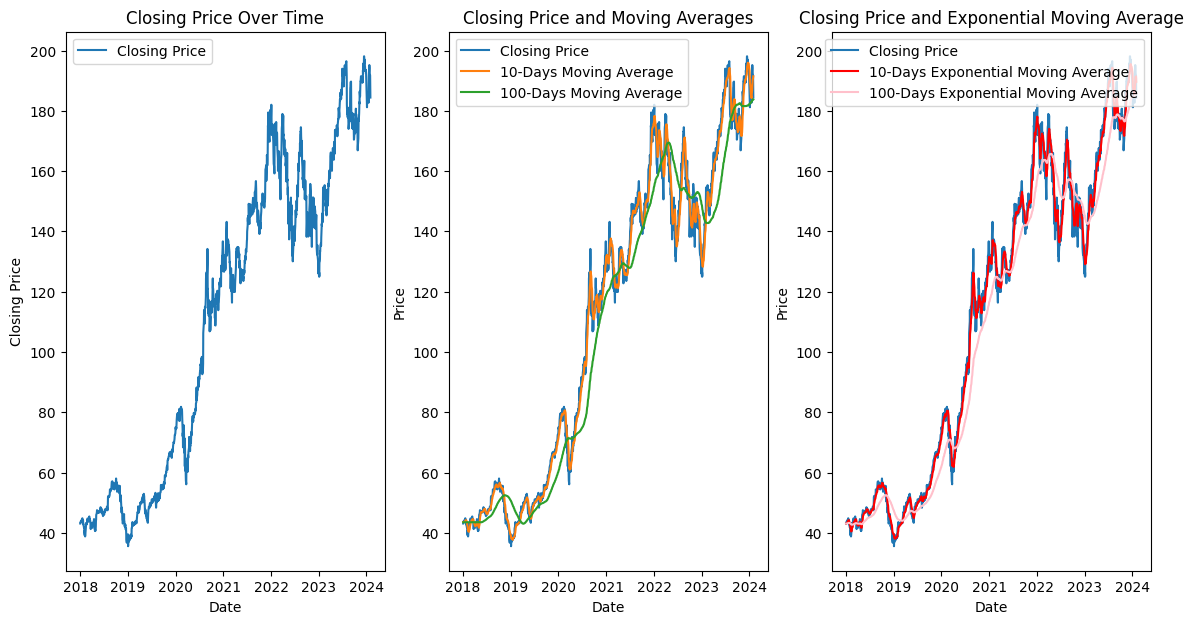

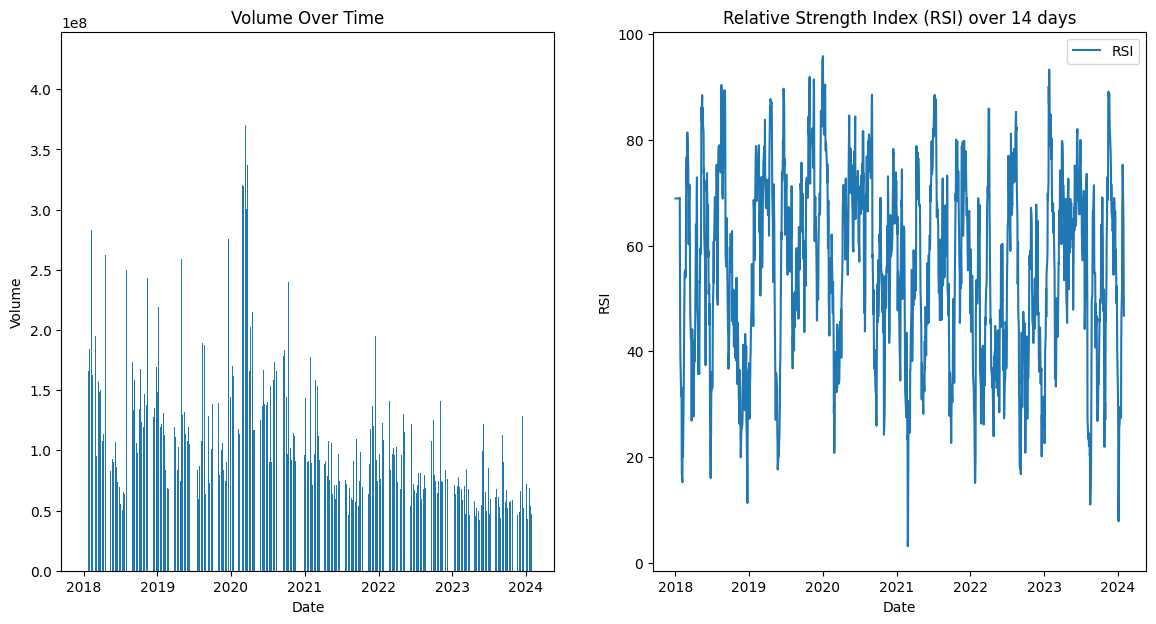

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# plt.figure(figsize=(14, 7))
# plt.subplot(1, 3, 1)
# plt.plot(stock_data['Close'], label='Closing Price')
# plt.title('Closing Price Over Time')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.legend()


# plt.subplot(1, 3, 2)
# plt.plot(stock_data['Close'], label='Closing Price')
# plt.plot(stock_data['SMA_10'], label='10-Days Moving Average')
# plt.plot(stock_data['SMA_100'], label='100-Days Moving Average')
# plt.title('Closing Price and Moving Averages')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(stock_data['Close'], label='Closing Price')
# plt.plot(stock_data['EMA_10'], label='10-Days Exponential Moving Average', c='red')
# plt.plot(stock_data['EMA_100'], label='100-Days Exponential Moving Average', c= 'pink')
# plt.title('Closing Price and Exponential Moving Average')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


# plt.figure(figsize=(14, 7))
# plt.subplot(1, 2, 1)
# plt.bar(stock_data.index, stock_data['Volume'])
# plt.title('Volume Over Time')
# plt.xlabel('Date')
# plt.ylabel('Volume')


# plt.subplot(1, 2, 2)
# plt.plot(stock_data['RSI_14'], label='RSI')
# plt.title('Relative Strength Index (RSI) over 14 days')
# plt.xlabel('Date')
# plt.ylabel('RSI')
# plt.legend()
# plt.show()


- **Plotting the Closing Prices**

We start by plotting the closing prices of the stock over time to observe the trend.

- **Plotting the Closing Prices and Moving Averages**

Next, we plot the closing prices along with the 10-day and 100-day simple moving averages (SMA) to identify trends and smoothing effects.

- **Plotting the Closing Prices and Exponential Moving Averages**

We also plot the closing prices along with the 10-day and 100-day exponential moving averages (EMA) to give more weight to recent prices.

- **Plotting the Volume**

We plot the trading volume to observe the activity and liquidity of the stock over time.

- **Plotting the Relative Strength Index (RSI)**

Finally, we plot the 14-day RSI to identify overbought or oversold conditions in the stock's price.


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Plotting the closing prices
fig = px.line(stock_data, x=stock_data.index, y='Close', title='Closing Price Over Time', labels={'Close': 'Closing Price'})
fig.show()


# Plotting the closing prices and the moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['SMA_10'], mode='lines', name='10-Days Moving Average'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['SMA_100'], mode='lines', name='100-Days Moving Average'))
fig.update_layout(title='Closing Price and Moving Averages', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Plotting the closing prices and the Exponential moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['EMA_10'], mode='lines', name='10-Days Exponential Moving Average'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['EMA_100'], mode='lines', name='100-Days Exponential Moving Average'))
fig.update_layout(title='Closing Price and Exponential Moving Averages', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Plotting the volume
fig = px.bar(stock_data, x=stock_data.index, y='Volume', title='Volume Over Time', labels={'Volume': 'Volume'})
fig.show()

# Plot RSI
fig = px.line(stock_data, x=stock_data.index, y=stock_data['RSI_14'], title='Relative Strength Index (RSI) over 14 days', labels={'RSI': 'RSI'})
fig.show()


###**Summary Statistics and Correlation Analysis**

- We display the summary statistics of the stock data using the `describe()` method. This provides a quick overview of the data distribution, including the count, mean, standard deviation, min, 25th percentile, median (50th percentile), 75th percentile, and max values for each feature.

- We compute the correlation matrix to identify the relationships between different features. This helps us understand which features are positively or negatively correlated with each other. The correlation matrix is displayed using a heatmap for better interpretation.



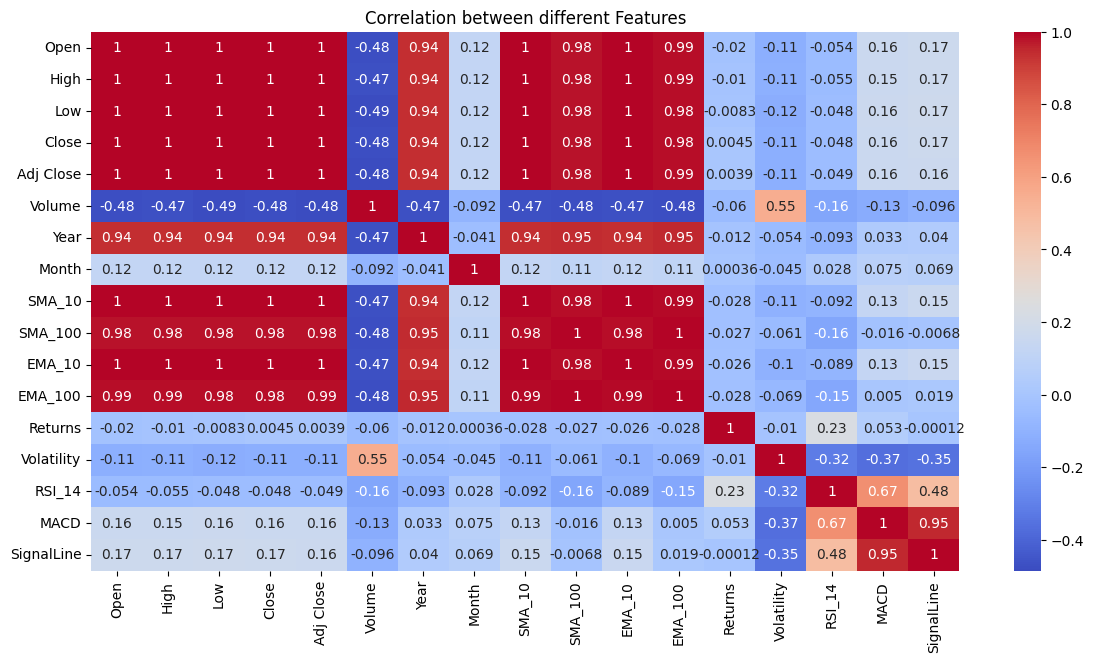

In [ ]:
# Summary statistics of the stock data
stock_data.describe()

# Correlation analysis
correlation_matrix = stock_data.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between different Features')
plt.show()

##**Bulding the Model**

###**Linear Regression model**

In this section, we will implement a Linear Regression model to predict the closing stock prices. We will perform **data splitting**, **feature scaling**, **model training**, **prediction**, and **evaluation**.


- **Libraries and Modules**

We import the necessary libraries and modules for data splitting, preprocessing, model training, and evaluation.

- **Data Splitting**

We split the data into training and testing sets. We use 70% of the data for training and 30% for testing. We set `shuffle=False` to maintain the temporal order of the data.

- **Feature Scaling**

We apply Standard Scaling to normalize the features, ensuring they have a mean of 0 and a standard deviation of 1. This helps improve the performance of the Linear Regression model.

- **Model Initialization and Training**

We initialize the Linear Regression model and fit it to the training data.

- **Model Prediction**

We use the trained model to predict the stock prices on the test data.

- **Model Evaluation**

We evaluate the model performance using Mean Squared Error (MSE) and R^2 Score. These metrics help us understand the accuracy and goodness-of-fit of the model.

**Mean Squared Error (MSE)**: Measures the average squared difference between the actual and predicted values.

**R^2 Score**: Indicates the proportion of variance in the dependent variable that is predictable from the independent variables.


We visualize the actual vs. predicted stock prices using **Plotly**. This helps in visually assessing the model's performance.


In [ ]:
# importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#split the data to train and test
data_train, data_test = train_test_split(stock_data, test_size=0.3, shuffle=False)
#np.isnan(data_train).any()
#np.isnan(data_test).any()

train_x = data_train.drop('Close', axis = 1)
train_y = data_train['Close']
test_x = data_test.drop('Close', axis = 1)
test_y = data_test['Close']

#train_x.shape
# test_x.shape


#Feature Scalling
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)


# Initialize and train the model
L_regressor = LinearRegression()
L_regressor.fit(train_x, train_y)

# Predict on the test data
pred_y = L_regressor.predict(test_x)


# Evaluating the Model results
mse = mean_squared_error(test_y, pred_y)

print(f'Mean Squared Error: {mse}')

r2 = r2_score(test_y, pred_y)
print(f'R^2 Score: {r2}')

# Plotting the results of Linear Regression model
results = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y}, index= test_y.index)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['Actual'], mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=results.index, y=results['Predicted'], mode='lines', name='Predicted', line=dict(color='red')))

fig.update_layout(title='Actual vs Predicted Stock Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(x=0, y=1))

fig.show()

Mean Squared Error: 0.42494537353078515
R^2 Score: 0.9988167844003365


###**Long-Short term Memory (LSTM) model for Stock Price Prediction**

In this section, we will implement an **LSTM** model to predict the closing stock prices. We will perform **data normalization**, **sequence creation**, **model building**, **training**, and **evaluation**.


- **Data Normalization**

We normalize the closing prices using MinMaxScaler to scale the values between 0 and 1. This helps in improving the performance of the LSTM model.

- **Sequence Creation**

We create sequences of data for the LSTM model. Each sequence will have a fixed length of 50, and the corresponding label will be the value that comes immediately after the sequence.


- **Data Splitting**

We manually split the data into training and testing sets. We use 80% of the data for training and 20% for testing.

- **Model Building and Training**

We build the **LSTM** model using the **Sequential API** from TensorFlow Keras. The model consists of two LSTM layers, each followed by a Dropout layer to prevent overfitting, and a Dense output layer. The model is compiled with the Adam optimizer and mean squared error loss function. We train the model for 50 epochs with a batch size of 16.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler


# Normalize the data
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled_stock_data = scaler1.fit_transform(stock_data[['Close']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 50
x, y = create_sequences(scaled_stock_data, sequence_length)

# Split the data Manually
split = int(0.8 * len(x))      # the split point
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Build and train the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.2)



Epoch 1/50
60/60 [==============================] - 9s 73ms/step - loss: 0.0169 - val_loss: 0.0021
Epoch 2/50
60/60 [==============================] - 4s 68ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 3/50
60/60 [==============================] - 3s 49ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 4/50
60/60 [==============================] - 3s 48ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/50
60/60 [==============================] - 3s 47ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/50
60/60 [==============================] - 4s 71ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/50
60/60 [==============================] - 3s 47ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/50
60/60 [==============================] - 3s 47ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/50
60/60 [==============================] - 4s 73ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/

- **Making Predictions**

We use the trained LSTM model to make predictions on the test data.

- **Inverse Scaling**

We inverse the scaling of the predicted values and the actual values to compare the results with the original closing prices.

- **Model Evaluation**

We evaluate the model's performance by calculating the ***Mean Squared Error (MSE)*** between the predicted and actual values. The actual vs predicted stock prices are visualize to evaluate the performance of the LSTM model.



In [ ]:
# Make predictions
y_pred = model.predict(x_test)

# inverse the scaling to compare the results with the actual values
y_pred = scaler1.inverse_transform(y_pred)
y_test = scaler1.inverse_transform(y_test)

# Evaluate the model
mse = np.mean((y_pred - y_test) ** 2) # mean squared error
print(f'Mean Squared Error: {mse}')

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):], y=y_test.flatten(), mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index[-len(y_pred):], y=y_pred.flatten(), mode='lines', name='Predicted', line=dict(color='red')))

fig.update_layout(title='Actual vs Predicted Stock Prices',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.show()

10/10 [==============================] - 1s 16ms/step
Mean Squared Error: 69.27212361713937


###**AutoRegressive Integrated Moving Average (ARIMA)**

In [ ]:
!pip install statsmodels pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

####**Checking for Outliers and Testing for Stationarity**
In this section, we will:

- Check for outliers in the stock price data using a boxplot.
- Test the stationarity of the closing price series using the Augmented ***Dickey-Fuller (ADF) test***.
- Apply differencing if the series is not stationary and re-test for stationarity.

- **Outlier Detection**

We use a boxplot to visually inspect the presence of outliers in the 'Close' price data.

- **Augmented Dickey-Fuller Test**

We perform the Augmented ***Dickey-Fuller (ADF) test*** to check for stationarity in the 'Close' price series.
The null hypothesis of the ADF test is that the series has a unit root, meaning it is non-stationary.
A p-value less than 0.05 indicates that we can reject the null hypothesis, suggesting the series is stationary.

- **Differencing to Remove Non-Stationarity**

If the series is found to be non-stationary, we apply differencing to make it stationary.
We then perform the ADF test again on the differenced series.

- **Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)**

The ***ACF*** and ***PACF*** plots help in identifying the order of the ARIMA model:

***ACF:*** Shows the correlation between the series and its lagged values. It helps to determine the value of ***q*** (order of the Moving Average part). The lag where the ACF crosses the significance threshold helps identify the value of q.

***PACF:*** Shows the partial correlation of the series with its lagged values, removing the effects of shorter lags. It helps to determine the value of ***p*** (order of the Autoregressive part). The lag where the PACF crosses the significance threshold helps identify the value of p.



ADF Statistic: -0.7727518945775049
p-value: 0.8269952706533696
Series is not stationary
ADF Statistic after differencing: -40.26662430487635
p-value after differencing: 0.0
Series is stationary after differencing


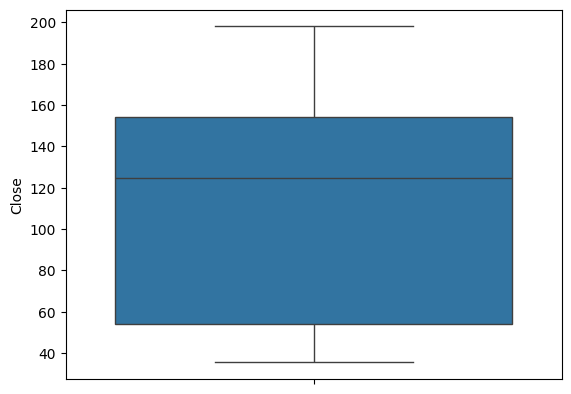

In [ ]:
#checking for outliers
sns.boxplot(stock_data['Close'])


# Check for stationarity with Augmented Dickey-Fuller test
result = adfuller(stock_data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')


# If not stationary, apply differencing
if result[1] > 0.05:
    stock_data['Close_diff'] = stock_data['Close'].diff().dropna()
    result_diff = adfuller(stock_data['Close_diff'].dropna())
    print('ADF Statistic after differencing:', result_diff[0])
    print('p-value after differencing:', result_diff[1])
    if result_diff[1] > 0.05:
        print('Series is still not stationary')
    else:
        print('Series is stationary after differencing')


#Plot ACF and PACF to find the potential values for p and q
fig, ax = plt.subplots(2, figsize=(12, 8))

# ACF plot
plot_acf(stock_data['Close_diff'].dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(stock_data['Close_diff'].dropna(), ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()



####**Fit the model on the differenced data**

- **Performing Grid Search to Find Optimal \( p, d, q \) Values**

We will use the `auto_arima` function to perform a grid search and find the best values for \( p \), \( d \), and \( q \) for our `ARIMA` model.

- **Building and Fitting the ARIMA Model with Optimal Parameters**

Using the optimal \( p, d, q \) values obtained from the grid search, we will now build and fit the ARIMA model.



In [ ]:
# Perform grid search to find the optimal p, d, q values
stepwise_fit = auto_arima(stock_data['Close'],
                          start_p=0, start_q=0,
                          max_p=5, max_q=5, m=1,
                          start_P=0, seasonal=False,
                          d=0, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)


#print(stepwise_fit.summary())

# Extract the optimal p, d, q values
p, d, q = stepwise_fit.order

# build and Fit the ARIMA model with optimal parameters on the stock data
model = ARIMA(stock_data['Close'], order=(p, d, q))
results = model.fit()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19064.168, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6799.608, Time=1.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6799.399, Time=1.68 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.52 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6797.259, Time=3.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=3.42 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6799.158, Time=7.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6779.893, Time=4.87 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6797.324, Time=3.65 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=6782.474, Time=6.85 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6781.859, Time=5.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6799.272, Time=3.71 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=6805.422, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

- **Forecasting the Next 30 Days**

We will use the `get_forecast` method from the `statsmodels` ARIMA model to generate predictions for the next 30 days. Additionally, we will create a DataFrame to hold the forecasted values along with their confidence intervals.

We generate a date range starting from the last date in the stock data to cover the next 30 business days. The forecast date range is generated to ensure it aligns correctly with the stock data's time index.


In [ ]:
# Forecast the next 30 days
forecast = results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_var = forecast.var_pred_mean
forecast_ci = forecast.conf_int()

#print(forecast_mean.isna().sum())

# Generate the correct date range for the forecast
last_date = stock_data.index[-1]
forecast_index = pd.date_range(start=last_date, periods=31, freq='B')[1:]  # Start from the next business day

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({
    'Date' : forecast_index,
    'Forecast': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
})

forecast_df.set_index('Date', inplace=True)
forecast_df.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



,Forecast,Lower CI,Upper CI
Date,,,
2024-02-01,184.224800,179.924246,188.525353
2024-02-02,184.418527,178.377749,190.459306
2024-02-05,184.223005,176.835392,191.610618
2024-02-06,184.391237,175.848529,192.933945
2024-02-07,184.262892,174.738939,193.786846


#### **Checking the Residuals**

- **Plotting the residuals**

Residuals are the differences between the ***observed values*** and the ***fitted values*** from the model. Plotting them helps us visually inspect if they behave like ***white noise***.

- **Autocorrelation of Residuals**

The autocorrelation function (ACF) plot helps us determine if the residuals have any remaining autocorrelation. Ideally, the residuals should not be autocorrelated.

- **Ljung-Box Test**

The Ljung-Box test checks whether any group of autocorrelations of the residuals is different from zero. A p-value greater than 0.05 indicates that the residuals are likely white noise.




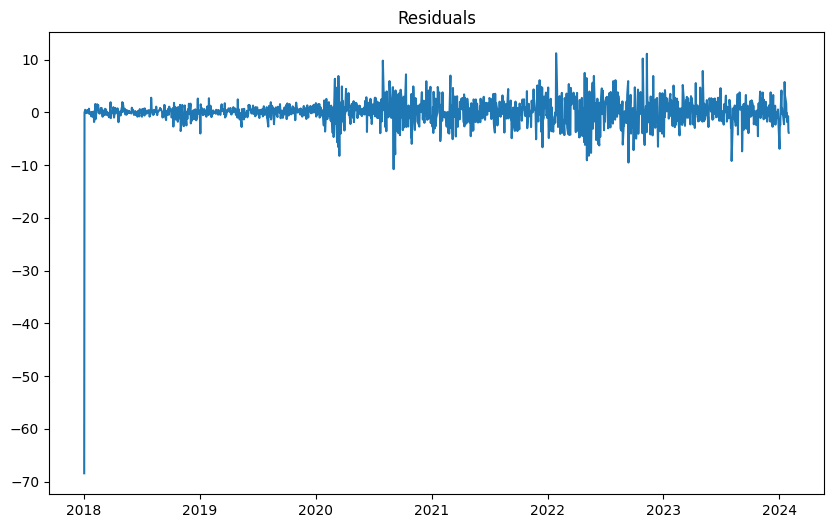

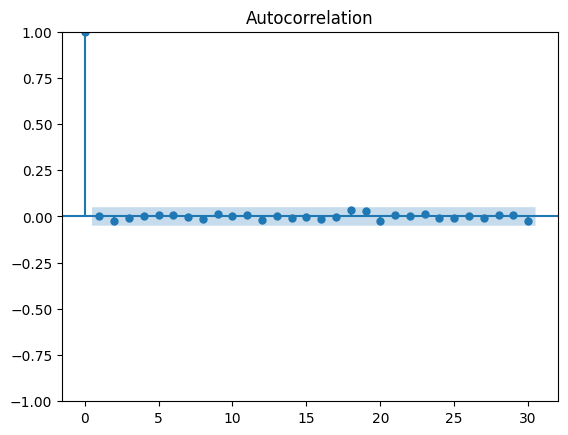

     lb_stat  lb_pvalue
10  1.881494    0.99717


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get the residuals
residuals = results.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=30)
plt.show()

# Ljung-Box test to check if the residuals are white noise
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


####**Trying other data transformation to acheive stationary data**

####**Log transforming the data**

- **Applying Log Transformation**

Log transformation helps in stabilizing the variance of the data. We apply this transformation to the 'Close' price of the stock.

- **Plotting the Log-Transformed Data**

After applying the log transformation, we plot the log-transformed closing price to observe its behavior over time.

- **Checking Stationarity**

The Augmented Dickey-Fuller (ADF) test is used to check if the log-transformed series is stationary. A p-value greater than 0.05 indicates non-stationarity.




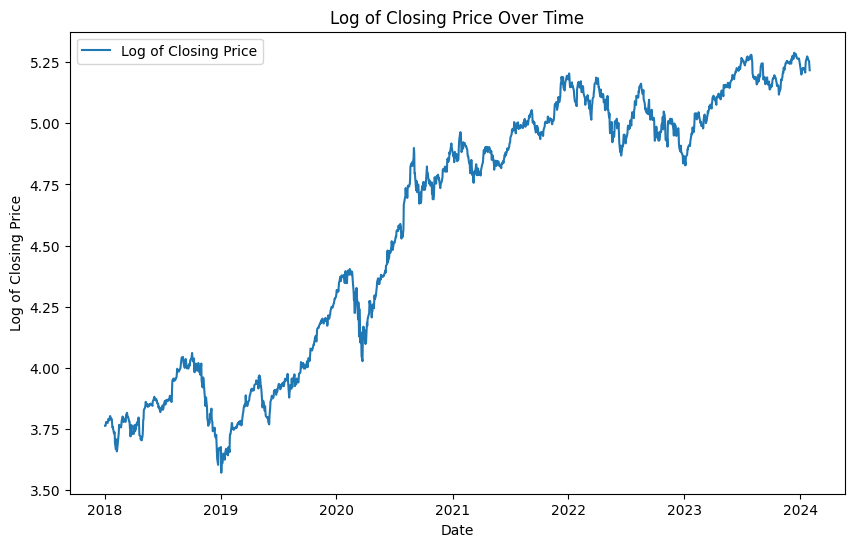

Series is still not stationary


In [ ]:
# Apply log transformation
stock_data['Log_Close'] = np.log(stock_data['Close'])

# Plot the log-transformed data
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Log_Close'], label='Log of Closing Price')
plt.title('Log of Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log of Closing Price')
plt.legend()
plt.show()

# Check stationarity of the log-transformed data
result_log = adfuller(stock_data['Log_Close'].dropna())

if result_log[1] > 0.05:
  print('Series is still not stationary')
else:
  print('Series is stationary after Log_transforming')

####**Square Root transformation to obtain stationary**


- **Apply Square Root transformation**

Square root transformation helps in stabilizing the variance of the data. We apply this transformation to the 'Close' price of the stock.

- **Plotting the Square Root Transformed Data**

After applying the square root transformation, we plot the square root transformed closing price to observe its behavior over time.

- **Checking Stationarity**

The Augmented Dickey-Fuller (ADF) test is used to check if the square root transformed series is stationary. A p-value greater than 0.05 indicates non-stationarity.



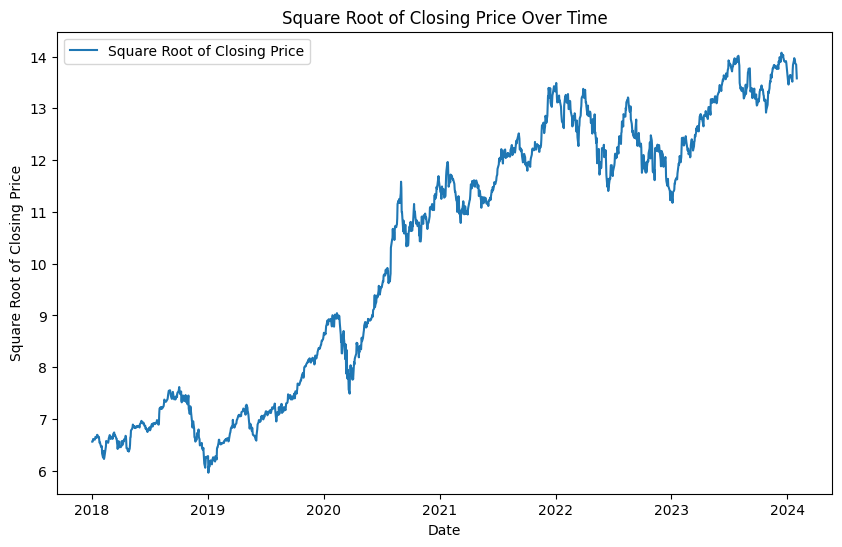

Series is still not stationary


In [ ]:
# Apply square root transformation
stock_data['Sqrt_Close'] = np.sqrt(stock_data['Close'])

# Plot the square root transformed data
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Sqrt_Close'], label='Square Root of Closing Price')
plt.title('Square Root of Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Square Root of Closing Price')
plt.legend()
plt.show()

# Check stationarity of the square root transformed data
result_sqrt = adfuller(stock_data['Sqrt_Close'].dropna())

if result_sqrt[1] > 0.05:
  print('Series is still not stationary')
else:
  print('Series is stationary after Sqrt_transforming')

####**Apply Boxcox transformation to obtain stationary**

- **Applying Box-Cox Transformation**

Box-Cox transformation helps in stabilizing the variance and making the data more normally distributed. We apply this transformation to the 'Close' price of the stock.

- **Plotting the Box-Cox Transformed Data**

After applying the Box-Cox transformation, we plot the transformed closing price to observe its behavior over time.

- **Lambda Value**

The lambda value used in the Box-Cox transformation is printed to understand the nature of the transformation applied.

- **Checking Stationarity**

The Augmented Dickey-Fuller (ADF) test is used to check if the Box-Cox transformed series is stationary. A p-value greater than 0.05 indicates non-stationarity.





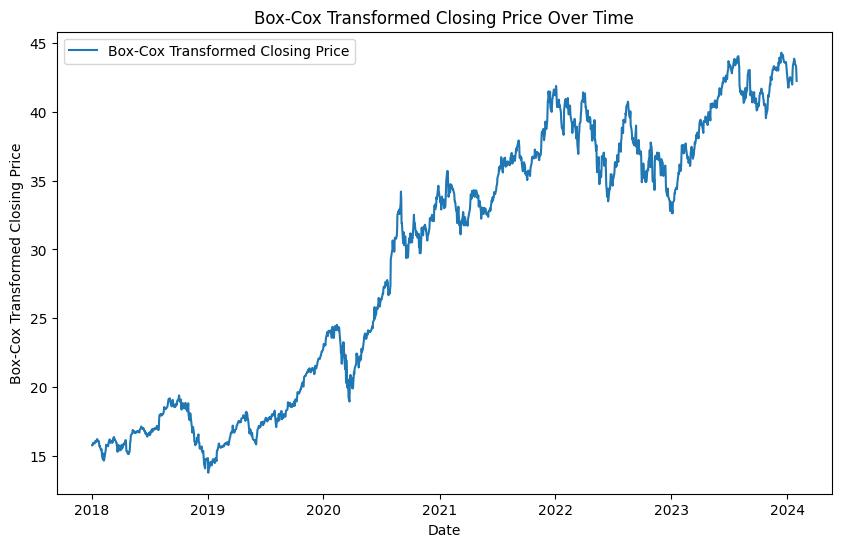

Lambda used for Box-Cox transformation: 0.6386311333123638
Series is still not stationary


In [ ]:
from scipy.stats import boxcox

# Apply Box-Cox transformation
stock_data['Close_BoxCox'], lmbda = boxcox(stock_data['Close'].dropna())

# Plot the Box-Cox transformed data
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Close_BoxCox'], label='Box-Cox Transformed Closing Price')
plt.title('Box-Cox Transformed Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Box-Cox Transformed Closing Price')
plt.legend()
plt.show()

# Print the lambda value
print(f"Lambda used for Box-Cox transformation: {lmbda}")


# Check stationarity of the Box-Cox transformed data
result_box = adfuller(stock_data['Close_BoxCox'].dropna())
if result_box[1] > 0.05:
  print('Series is still not stationary')
else:
  print('Series is stationary after Box-Cox transforming')

#### **Plotting the Forecast with Confidence Intervals using Plotly**

We will create a plot that shows the historical data, the forecasted values, and the confidence intervals. The plot will be interactive, allowing users to explore the data dynamical

- **Historical Data:** Added as a line plot using go.Scatter.
- **Forecasted Data:** Added as a line plot with a red color to distinguish it from the historical data.
- **Confidence Interval:** Added as a shaded area plot using fill='toself'. The confidence interval is created by combining the upper and lower bounds of the forecast

In [ ]:
# Plot the forecast
fig = go.Figure()

# Plot historical data
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Observed'))

# Plot forecasted data
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Forecast', line=dict(color='red')))

# Plot confidence interval
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index.tolist()[::-1],
    y=forecast_df['Upper CI'].tolist() + forecast_df['Lower CI'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',
    line=dict(color='rgba(255, 182, 193, 0)'),
    name='Confidence Interval'
))

fig.update_layout(
    title='Closing Price Forecast with Confidence Intervals',
    xaxis_title='Date',
    yaxis_title='Closing Price',
    showlegend=True
)

fig.show()